In [1]:
import pandas as pd
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
import os
import cv2
from keras.layers import SpatialDropout2D, Dense, Activation, Flatten, Dropout, GlobalAveragePooling2D, GlobalMaxPooling2D, Conv2D, BatchNormalization, MaxPooling2D, Input, Concatenate, ReLU, AveragePooling2D, UpSampling2D
# from tensorflow.keras.applications import DenseNet201, InceptionResNetV2, MobileNetV2, EfficientNetB3, Xception, VGG19, InceptionV3, EfficientNetB0, EfficientNetB2, Xception
from tensorflow.keras import regularizers, Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import Sequence
from keras.models import Model
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import SGD, Adam
import keras
import numpy as np
import random
import shutil

In [2]:
from tensorflow.keras.applications import ResNet50

In [3]:
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
target = 224

# inject noise but keep dark parts black
def addNoise(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY).astype(np.float64)
    ret, mask = cv2.threshold(gray, 5, 255, cv2.THRESH_BINARY)
    randStd = random.uniform(0, 10.0) # 15
    gaussian = np.random.normal(randStd*-1, randStd)
    noisy_image = image + gaussian
    image = np.clip(noisy_image, 0, 255).astype(np.float64)
    image[mask == 0] = [0,0,0]
    image = preprocess_input(image)
    return image

dataPath = 'final/'

# combine two unique generators using noise injection
batchSize = 4
trainDataGen = ImageDataGenerator(preprocessing_function=addNoise,horizontal_flip=True,vertical_flip=True,rotation_range=0,brightness_range=(0.95, 1.05),rescale=1./255)
trainGen1 = trainDataGen.flow_from_directory(batch_size = batchSize, shuffle=True,  class_mode="binary", directory=dataPath + '/train', color_mode='rgb', seed=0,target_size=(224, 224))
trainGen2 = trainDataGen.flow_from_directory(batch_size = batchSize, shuffle=True,  class_mode="binary", directory=dataPath + '/train', color_mode='rgb', seed=1,target_size=(224, 224))

def combine_gen(*gens):
    while True:
        for g in gens:
            yield next(g)

trainGen = combine_gen(trainGen1, trainGen2)

valDataGen = ImageDataGenerator(preprocessing_function=preprocess_input,rescale=1./255)
valGen = valDataGen.flow_from_directory(batch_size = 1, class_mode="binary", directory=dataPath + 'validation', color_mode='rgb',target_size=(224, 224))

testDataGen = ImageDataGenerator(preprocessing_function=preprocess_input,rescale=1./255)
testGen = testDataGen.flow_from_directory(batch_size = 1, class_mode="binary", directory=dataPath + 'test', color_mode='rgb',target_size=(224, 224))

Found 568 images belonging to 2 classes.
Found 568 images belonging to 2 classes.
Found 72 images belonging to 2 classes.
Found 72 images belonging to 2 classes.


In [4]:
# def addNoise(image):
#     gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).astype(np.uint8)
#     ret, mask = cv2.threshold(gray, 5, 255, cv2.THRESH_BINARY)

#     randStd = random.uniform(0, 10.0) 
#     gaussian = np.random.normal(randStd*-1, randStd, (target, target, 3))
#     noisy_image = image + gaussian
#     image = np.clip(noisy_image, 0, 255).astype(np.uint8)

#     image[mask == 0] = [0,0,0]
#     return image  # Return the noisy image

In [5]:
# import cv2
# import numpy as np
# image_path = 'demotest/demo.png'  # Replace with your image path
# image = cv2.imread(image_path)  
# target=224

In [6]:
# def addNoise(image):
#     gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY).astype(np.uint8)
#     print(f"Image dtype after grayscale conversion: {gray.dtype}")  

#     ret, mask = cv2.threshold(gray, 5, 255, cv2.THRESH_BINARY)
#     print(f"Image dtype after thresholding: {image.dtype}")

#     randStd = random.uniform(0, 10.0)
#     gaussian = np.random.normal(randStd*-1, randStd, image.shape) # Match the shape of the image 

#     print(f"Image dtype after creating noise: {image.dtype}") 

#     noisy_image = image + gaussian
#     noisy_image = noisy_image.astype(np.uint8) 
#     print(f"Image dtype after adding noise: {noisy_image.dtype}") 
    
#     image = np.clip(noisy_image, 0, 255).astype(np.uint8)
#     print(f"Image dtype after clipping:{image.dtype}")

#     image[mask == 0] = [0,0,0]

#     return image


In [7]:
# noisy_image = addNoise(image.copy())  # Create a copy to preserve the original

# cv2.imshow("Original Image", image)
# cv2.imshow("Noisy Image", noisy_image )
# cv2.waitKey(1)  
# cv2.destroyAllWindows()



In [8]:
from keras.layers.pooling.global_max_pooling2d import GlobalMaxPool2D

# simple model that uses mobilenet background
def getModel(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    
    transfer = keras.applications.MobileNetV3Large(
        weights=None, include_top=False, input_tensor=model_input
    )
    x = transfer.get_layer(index=142).output
    
    x = SpatialDropout2D(0.15)(x)
    x = Conv2D(filters=64, kernel_size=1, activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-1))(x)
    x = GlobalMaxPool2D()(x)
    x = Dropout(0.15)(x)

    model_output = Dense(1, activation='sigmoid') (x)

    return keras.Model(inputs=model_input, outputs=model_output)

model = getModel(image_size=target, num_classes=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.85, patience=2, min_lr=1e-5) # factor=0.85
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath='val-best.h5',
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling[0][0]']              
                                )                                                                 
                                                                                              

                                                                                                  
 expanded_conv_2/depthwise/Batc  (None, 56, 56, 72)  288         ['expanded_conv_2/depthwise[0][0]
 hNorm (BatchNormalization)                                      ']                               
                                                                                                  
 re_lu_5 (ReLU)                 (None, 56, 56, 72)   0           ['expanded_conv_2/depthwise/Batch
                                                                 Norm[0][0]']                     
                                                                                                  
 expanded_conv_2/project (Conv2  (None, 56, 56, 24)  1728        ['re_lu_5[0][0]']                
 D)                                                                                               
                                                                                                  
 expanded_

                                                                                                  
 re_lu_10 (ReLU)                (None, 28, 28, 120)  0           ['expanded_conv_4/depthwise/Batch
                                                                 Norm[0][0]']                     
                                                                                                  
 expanded_conv_4/squeeze_excite  (None, 1, 1, 120)   0           ['re_lu_10[0][0]']               
 /AvgPool (GlobalAveragePooling                                                                   
 2D)                                                                                              
                                                                                                  
 expanded_conv_4/squeeze_excite  (None, 1, 1, 32)    3872        ['expanded_conv_4/squeeze_excite/
 /Conv (Conv2D)                                                  AvgPool[0][0]']                  
          

                                                                                                  
 expanded_conv_5/project/BatchN  (None, 28, 28, 40)  160         ['expanded_conv_5/project[0][0]']
 orm (BatchNormalization)                                                                         
                                                                                                  
 expanded_conv_5/Add (Add)      (None, 28, 28, 40)   0           ['expanded_conv_4/Add[0][0]',    
                                                                  'expanded_conv_5/project/BatchNo
                                                                 rm[0][0]']                       
                                                                                                  
 expanded_conv_6/expand (Conv2D  (None, 28, 28, 240)  9600       ['expanded_conv_5/Add[0][0]']    
 )                                                                                                
          

 )                                                                                                
                                                                                                  
 multiply_4 (Multiply)          (None, 14, 14, 200)  0           ['expanded_conv_7/depthwise/Batch
                                                                 Norm[0][0]',                     
                                                                  'tf.math.multiply_7[0][0]']     
                                                                                                  
 expanded_conv_7/project (Conv2  (None, 14, 14, 80)  16000       ['multiply_4[0][0]']             
 D)                                                                                               
                                                                                                  
 expanded_conv_7/project/BatchN  (None, 14, 14, 80)  320         ['expanded_conv_7/project[0][0]']
 orm (Batc

                                                                                                  
 expanded_conv_9/depthwise/Batc  (None, 14, 14, 184)  736        ['expanded_conv_9/depthwise[0][0]
 hNorm (BatchNormalization)                                      ']                               
                                                                                                  
 tf.__operators__.add_11 (TFOpL  (None, 14, 14, 184)  0          ['expanded_conv_9/depthwise/Batch
 ambda)                                                          Norm[0][0]']                     
                                                                                                  
 re_lu_22 (ReLU)                (None, 14, 14, 184)  0           ['tf.__operators__.add_11[0][0]']
                                                                                                  
 tf.math.multiply_11 (TFOpLambd  (None, 14, 14, 184)  0          ['re_lu_22[0][0]']               
 a)       

In [10]:
model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['binary_accuracy',keras.metrics.AUC(),keras.metrics.Precision(), keras.metrics.Recall()])
history = model.fit(trainGen, steps_per_epoch = len(trainGen1)*2,validation_data=valGen, validation_steps=len(valGen), epochs=30, callbacks=[reduce_lr, model_checkpoint_callback])

Epoch 1/30
284/284 [==============================] - 36s 74ms/step - loss: 51.4950 - binary_accuracy: 0.5018 - auc: 0.5011 - precision: 0.5018 - recall: 0.4806 - val_loss: 46.5647 - val_binary_accuracy: 0.5000 - val_auc: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/30
284/284 [==============================] - 18s 62ms/step - loss: 44.8305 - binary_accuracy: 0.5264 - auc: 0.5203 - precision: 0.5272 - recall: 0.5123 - val_loss: 40.5984 - val_binary_accuracy: 0.5000 - val_auc: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 1.0000e-04
Epoch 3/30
284/284 [==============================] - 18s 62ms/step - loss: 38.6801 - binary_accuracy: 0.5167 - auc: 0.5159 - precision: 0.5171 - recall: 0.5053 - val_loss: 34.8705 - val_binary_accuracy: 0.5000 - val_auc: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 1.0000e-04
Epoch 4/30
284/284 [==============================] - 17s 62ms/step - loss: 32.8479 - binary_accuracy: 

Epoch 29/30
284/284 [==============================] - 19s 66ms/step - loss: 0.6976 - binary_accuracy: 0.5660 - auc: 0.5778 - precision: 0.5666 - recall: 0.5616 - val_loss: 19.7417 - val_binary_accuracy: 0.5000 - val_auc: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 6.1412e-05
Epoch 30/30
284/284 [==============================] - 19s 66ms/step - loss: 0.6949 - binary_accuracy: 0.5678 - auc: 0.5880 - precision: 0.5739 - recall: 0.5264 - val_loss: 6.4237 - val_binary_accuracy: 0.5000 - val_auc: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 5.2201e-05


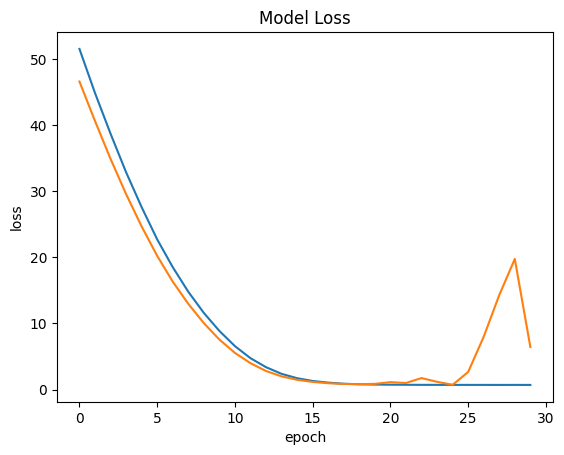

In [11]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

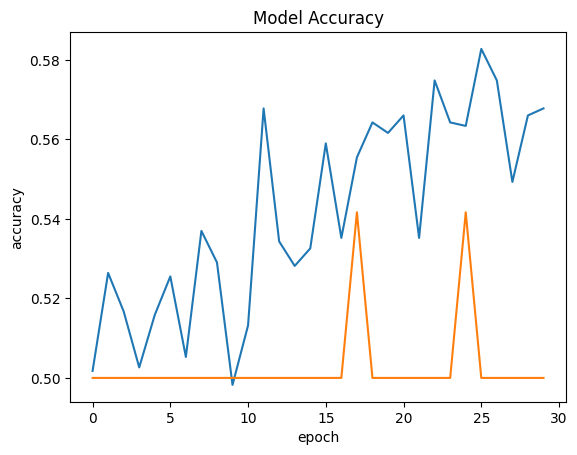

In [12]:
plt.plot(history.history["binary_accuracy"])
plt.plot(history.history["val_binary_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

In [13]:
model.evaluate(testGen)

72/72 [==============================] - 1s 16ms/step - loss: 6.4111 - binary_accuracy: 0.5000 - auc: 0.5000 - precision: 0.0000e+00 - recall: 0.0000e+00


[6.4110918045043945, 0.5, 0.5, 0.0, 0.0]

In [14]:
model.load_weights('val-best.h5')

In [15]:
model.evaluate(testGen)

72/72 [==============================] - 1s 15ms/step - loss: 0.7101 - binary_accuracy: 0.5139 - auc: 0.4506 - precision: 0.5200 - recall: 0.3611


[0.710100531578064,
 0.5138888955116272,
 0.4506172835826874,
 0.5199999809265137,
 0.3611111044883728]